In [1]:
from IPython.display import clear_output, Image, display, HTML
from collections import deque
from typing import Deque, Dict, List, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
import pygame as pygame
import numpy as np
import asyncio
import nest_asyncio
import random
import cv2
import os
import gc
import json
nest_asyncio.apply()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import torch as t
import torch.nn as nn
from torchinfo import summary

In [3]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
XRES = 800
YRES = 600
FACTOR = 8
XRES_SCALED = int(XRES / FACTOR)
YRES_SCALED = int(YRES / FACTOR)
TICKS_REF = 80
ACTION_SIZE = 4
FRAME_SKIP = 3
STATE_SIZE = (1, 3, YRES_SCALED, XRES_SCALED)
assert len(STATE_SIZE) == 4
BATCH_SIZE = 32
MEMORY_DEPTH = 100_000
SCREEN = pygame.display.set_mode((XRES, YRES))
MODEL_FILE = 'space_model_TRANS.pt'
STATS_FILE = 'stats_TRANS.json'
LEARNING_RATE = 0.0003

if t.cuda.is_available():
    DEVICE = t.device('cuda')
else:
    DEVICE = t.device('cpu')
print('DEVICE:', DEVICE)

DEVICE: cuda


In [4]:
from game_v2 import SpaceInvaders
from segment_tree import MinSegmentTree, SumSegmentTree

In [5]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim[0], obs_dim[1], obs_dim[2], obs_dim[3]], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim[0], obs_dim[1], obs_dim[2], obs_dim[3]], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

In [6]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6,
        n_step: int = 1, 
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

In [7]:
class DDTQN(nn.Module):
    def __init__(self, state_size_f, action_size, hidden_cells=128, hidden_layers=5):
        super().__init__()
        self.transformer_layer = nn.Sequential(
            nn.Linear(state_size_f, hidden_cells),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_cells, nhead=2, batch_first=True), num_layers=hidden_layers),
        )
        # Advantage Layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(hidden_cells, 256),
            nn.ReLU(),
            nn.Linear(256, action_size),
        )
        # Value layer
        self.value_layer = nn.Sequential(
            nn.Linear(hidden_cells, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def trans_forward(self, x, hidden=None):
        x = self.transformer_layer(x)
        value = self.value_layer(x)
        advantage = self.advantage_layer(x)
        qvalue = value + advantage - advantage.mean(dim=-1, keepdim=True)
        return qvalue, None

In [8]:
class convolution(DDTQN):
    def __init__(self, action_size, state_size_f):
        super().__init__(state_size_f, action_size)
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(8,8), stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(8,8), stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(4,4), stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=(4,4), stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3072, state_size_f),
        )

In [9]:
class SpaceModel(convolution):
    def __init__(self, state_size_i, action_size, state_size_f):
        self.action_size = action_size
        self.state_size_i = state_size_i
        self.state_size_f = state_size_f
        super().__init__(action_size=self.action_size, state_size_f=self.state_size_f)

    def forward(self, x, hidden=None):
        _, time_steps, C, H, W = x.size()
        output = t.tensor([]).to(DEVICE)
        for i in range(time_steps):
            input = x[:, i, :, :, :].clone()
            out = self.conv_layer(input)
            output = t.cat((output, out.unsqueeze(1)), 1)
        out, hidden = self.trans_forward(output, hidden)
        return out.squeeze(1), hidden

In [10]:
model = SpaceModel(STATE_SIZE, ACTION_SIZE, 256).to(DEVICE)
summary(model, (BATCH_SIZE, 1, 3, YRES_SCALED, XRES_SCALED),)

Layer (type:depth-idx)                             Output Shape              Param #
SpaceModel                                         [32, 4]                   --
├─Sequential: 1-1                                  [32, 256]                 --
│    └─Conv2d: 2-1                                 [32, 64, 34, 47]          12,352
│    └─ReLU: 2-2                                   [32, 64, 34, 47]          --
│    └─Conv2d: 2-3                                 [32, 128, 14, 20]         524,416
│    └─ReLU: 2-4                                   [32, 128, 14, 20]         --
│    └─Conv2d: 2-5                                 [32, 256, 6, 9]           524,544
│    └─ReLU: 2-6                                   [32, 256, 6, 9]           --
│    └─Conv2d: 2-7                                 [32, 512, 2, 3]           2,097,664
│    └─ReLU: 2-8                                   [32, 512, 2, 3]           --
│    └─Flatten: 2-9                                [32, 3072]                --
│    └─Linear:

In [11]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99 # discount rate
        self.frame_skip = FRAME_SKIP
        
        # PER
        self.alpha = 0.2
        self.beta = 0.6
        self.prior_eps = 1e-6
        self.memory = PrioritizedReplayBuffer(self.state_size, MEMORY_DEPTH, BATCH_SIZE, alpha=self.alpha, gamma=self.gamma)
        self.n_step = 3 # N-step Learning
        self.memory_n = ReplayBuffer(self.state_size, MEMORY_DEPTH, BATCH_SIZE, n_step=self.n_step, gamma=self.gamma)

        # Greedy Epsilon
        self.epsilon_max = 1.00 # initial exploration rate
        self.epsilon_min = 0.10 # final exploration rate
        self.epsilon = self.epsilon_max
        self.epsilon_target = 1000

        # Models
        self.model = SpaceModel(self.state_size, self.action_size, 256).to(DEVICE)
        self.model_hidden = None
        self.target_model = SpaceModel(self.state_size, self.action_size, 256).to(DEVICE)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.target_step = 0
        self.target_update = 100

        # Training
        self.optimizer = t.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss(reduction="none")
        self.training = True
        self.transition = list()
        self.frame_idx = 0

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action_id = random.randrange(self.action_size)
        else:
            action, self.model_hidden = self.model(t.tensor(state[np.newaxis, :]).to(DEVICE), self.model_hidden)
            action = action.cpu().detach().numpy()
            action_id = np.argmax(action[0])
            print(action_id, action)
        return action_id

    def play(self, game, episode, max_episodes=1000, stats=None):
        # Retrieve action to play
        state = game.get_state()
        state = state[np.newaxis, :] # For transformer seq.
        action = self.act(state)

        # Step game with frame skipping
        reward = 0
        for _ in range(self.frame_skip):
            next_state, r, done = game.step(action=action)
            next_state = next_state[np.newaxis, :] # For transformer seq.
            reward += r
            if done:
                break

        if self.training:
            # Initial transition
            self.transition = [state, action]
            # Final transition
            self.transition += [reward, next_state, done]
            
            # N-step transition
            one_step_transition = self.memory_n.store(*self.transition)

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)

            # PER: increase beta
            self.episode_idx = episode + 1
            fraction = min(self.episode_idx / max_episodes, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # Train if needed
            if len(self.memory) >= BATCH_SIZE:
                loss, batch_reward = self.train_model()

                # Epsilon decay
                self.epsilon = max(
                    self.epsilon_min,
                    (((self.epsilon_min - self.epsilon_max) / self.epsilon_target) * episode + self.epsilon_max)
                )

                if stats is not None:
                    stats['losses'].append(loss)
                    stats['rewards'].append(batch_reward)
                    stats['epoch'].append(self.target_step)
                    stats['epsilon'].append(self.epsilon)

                self.target_step += 1
                if self.target_step % self.target_update == 0:
                    self.target_model.load_state_dict(self.model.state_dict())

        if done:
            self.model_hidden = None
            if stats is not None:
                stats['scores'].append(game.score)
                stats['episode'].append(episode)

        return done

    def compute_loss(self, samples, gamma):
        state = t.FloatTensor(samples["obs"]).to(DEVICE)
        next_state = t.FloatTensor(samples["next_obs"]).to(DEVICE)
        action = t.LongTensor(samples["acts"].reshape(-1, 1)).to(DEVICE)
        reward = t.FloatTensor(samples["rews"].reshape(-1, 1)).to(DEVICE)
        done = t.FloatTensor(samples["done"].reshape(-1, 1)).to(DEVICE)

        hidden = None
        if self.model_hidden is not None:
            hx, cx = self.model_hidden
            hx, cx = hx.detach(), cx.detach()
            hidden = (hx, cx)

        curr_q_value = self.model(state, hidden)[0].gather(1, action)
        next_q_value = self.target_model(next_state, hidden)[0].max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(DEVICE)

        # Calculate Loss and Average Batch Reward
        return self.criterion(curr_q_value, target), np.mean(samples["rews"])

    def train_model(self):
        batch_reward = 0

        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = t.tensor(samples["weights"].reshape(-1, 1)).to(DEVICE)
        indices = samples["indices"]

        # 1-step Learning loss
        elementwise_loss, r = self.compute_loss(samples, self.gamma)
        batch_reward += r

        # N-step Learning loss
        gamma = self.gamma ** self.n_step
        samples = self.memory_n.sample_batch_from_idxs(indices)
        elementwise_loss_n_loss, r = self.compute_loss(samples, gamma)
        elementwise_loss += elementwise_loss_n_loss
        batch_reward += r

        # PER: importance sampling before average
        loss = t.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior
        new_priorities[new_priorities < self.prior_eps] = self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        return loss.item(), batch_reward

    def save(self, path):
        t.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(t.load(path))
        self.target_model.load_state_dict(t.load(path))

In [12]:
agent = Agent(STATE_SIZE, ACTION_SIZE)
game = SpaceInvaders(SCREEN, agent, XRES_SCALED, YRES_SCALED, TICKS_REF)
stats = dict({
    'scores': [],
    'epsilon': [],
    'rewards': [],
    'epoch': [],
    'episode': [],
    'losses': [],
})
episode_count = 0

In [13]:
async def update_screen(display_handle, screen, stats, fig, ax):
    def batch_mean(x, w):
      s_len = len(x) - len(x) % w
      s = x[0:s_len]
      s_x = np.array(np.array_split(s, len(s) // w, axis=0))
      avg = np.mean(s_x, axis=1)
      s_len = len(avg)
      x_ticks = range(w, (s_len+ 1) * w, w)
      return avg, s_len, x_ticks

    def running_mean(x, w):
      avg = np.convolve(x, np.ones(w), 'valid') / w
      s_len = len(avg)
      return avg, s_len, range(0, s_len, 1)

    view = pygame.surfarray.array3d(screen)

    #  convert from (width, height, channel) to (height, width, channel)
    scores = np.array(stats['scores'])
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    img_bgr = cv2.putText(img_bgr,
        str(np.round(np.mean(scores), decimals=2)) + "/" +
        str(np.max(scores, initial=0)) + "/" +
        str(len(scores)) + "/" +
        str(agent.epsilon),
        (0, YRES-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    img_bgr = cv2.resize(img_bgr, (500, 400), None)

    plot = False
    if len(scores) > 100 * 2:
        avg, s_len, x_ticks = batch_mean(scores, 100)
        plot = True
    elif len(scores) > 0:
        avg, s_len, x_ticks = running_mean(scores, 10)
        plot = True
    
    if plot:
        z = np.zeros_like(avg)
        if len(avg) > 1:
            z = np.polyfit(range(s_len), avg, 1)
        p = np.poly1d(z)

        ax.plot(x_ticks, avg)
        ax.plot(x_ticks, p(range(s_len)))

    fig.suptitle("Average Score")

    # convert canvas to image
    fig.canvas.draw()
    fig.canvas.flush_events()
    img_sts = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img_sts = img_sts.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    ax.cla()

    # img is rgb, convert to opencv's default bgr
    img_sts = cv2.cvtColor(img_sts, cv2.COLOR_RGB2BGR)
    img_sts = cv2.resize(img_sts, (500, 400), None)
    img = np.hstack((img_bgr, img_sts))
    ret, img_data = cv2.imencode(".jpg", img)
    assert ret
    clear_output(wait=True)
    display_handle.display(Image(data=img_data.tobytes()))
    del img_data

In [14]:
def run_game(game, agent, stats=None, episodes=-1, train=True, display_res=10, display_fig=True):
    display_handle = display(None, display_id=True)
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.ion()

    display_cnt = 0
    episode = 0
    agent.training = train
    while episode <= episodes:
        episode += 1
        game.reset(0)
        game.start()
        done = False
        while not done:
            done = agent.play(game, episode, max_episodes=agent.epsilon_target, stats=stats)
            display_cnt += 1
            if display_fig and (done or display_cnt % display_res == 0):
                asyncio.run(update_screen(display_handle, SCREEN, stats, fig, ax))

        # Save model and stats if needed
        if stats is not None:
            with open(STATS_FILE, 'w') as fout:
                json.dump(stats, fout)
            agent.save(MODEL_FILE)

        # Cleanup memory
        gc.collect()

In [ ]:
# To restore saved state
if os.path.exists(MODEL_FILE):
    agent.load(MODEL_FILE)
    print("restoring model to: " + MODEL_FILE)
if os.path.exists(STATS_FILE):
    with open(STATS_FILE, "r") as f:
        stats = json.load(f)
    print("restoring stats to: " + STATS_FILE)

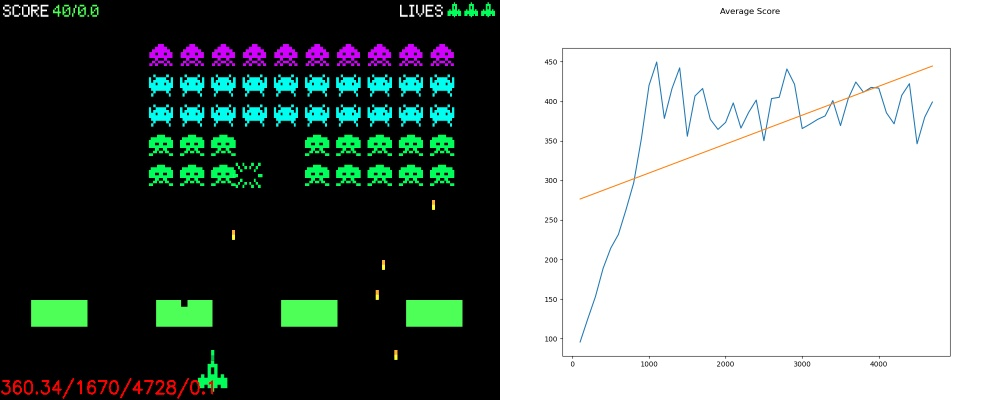

1 [[138.39445 138.86728 137.72253 137.01367]]
1 [[138.57118 139.04404 137.89932 137.19037]]
1 [[138.62292 139.09578 137.9511  137.24208]]
1 [[138.6122  139.08505 137.9404  137.23132]]


In [15]:
# For Training
run_game(game, agent, stats=stats, episodes=5000, train=True, display_res=20, display_fig=True)

In [ ]:
# For Visualizing
run_game(game, agent, stats=None, episodes=5, train=False, display_res=1, display_fig=True)

### References

Title: Deep Reinforcement Learning to play Space Invaders
Link: https://nihit.github.io/resources/spaceinvaders.pdf
Type: Paper

Title: Frame Skipping and Pre-Processing for Deep Q-Networks on Atari 2600 Games
Link: https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
Type: Blog Post

Title: GuarDiqN: Playing Space Invader with Dueling Double Deep Q-Network
Link: https://github.com/lychengrex/Playing-Space-Invaders-with-Deep-Q-Networks/tree/master
Type: Source Code

Title: Improving the DQN algorithm using Double Q-Learning
Link: https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/11/double-dqn.html
Type: Blog Post

Title: Double Q-learning
Link: https://proceedings.neurips.cc/paper_files/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf
Type: Paper

Title: Deep reinforcement learning with pixel features in Atari Pong Game
Link: https://github.com/gznyyb/deep_reinforcement_learning_Pong/tree/master
Type: Source Code

Title: TRAIN A MARIO-PLAYING RL AGENT
Link: https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
Type: Blog Post

Title: Playing Super Mario Bros with Deep Reinforcement Learning
Link: https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
Type: Blog Post

Title: Deep Reinforcement Learning with Space Invaders… Literally from scratch
Link: https://yaassinekaddi.medium.com/deep-reinforcement-learning-with-space-invaders-literally-from-scratch-part-i-10905fe04846
Type: Blog Post

Title: Asynchronous Methods for Deep Reinforcement Learning
Link: https://arxiv.org/pdf/1602.01783.pdf
Type: Paper

Title: Reinforcement-Learning-Atari-Games
Link: https://github.com/NitishMutha/Reinforcement-Learning-Atari-Games/tree/master
Type: Source Code

Title: Practical Reinforcement Learning — 02 Getting started with Q-learning
Link: https://towardsdatascience.com/practical-reinforcement-learning-02-getting-started-with-q-learning-582f63e4acd9
Type: Blog Post

Title: Playing Atari with Deep Reinforcement Learning
Link: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
Type: Paper

Title: RL
Link: https://github.com/msachin93/RL
Type: Source Code

Title: Space Invaders challenge: a Reinforcement Learning competition
Link: https://wandb.ai/raghmura/qualcomm/reports/Space-Invaders-challenge-a-Reinforcement-Learning-competition--Vmlldzo5MzEzMg
Type: Blog Post